In [9]:
import simpegDarcy as Darcy
import simpegSP as SP
from SimPEG import Mesh, Maps, Utils
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
csx, csy, csz = 5., 5., 2.5
ncx, ncy, ncz = 30, 30, 20
hx = [(csx, 5, -1.3), (csx, ncx), (csx, 5, 1.3)]
hy = [(csy, 5, -1.3), (csy, ncy), (csy, 5, -1.3),]
hz = [(csz, 5, -1.3), (csz, ncz-4), (csz/2., 4)]
mesh = Mesh.TensorMesh([hx, hy, hz], "CC0")
mesh._x0 = np.r_[mesh.x0[0], mesh.x0[1], -mesh.hz[:5].sum()]
Darcyprb = Darcy.Problem_CC(mesh, KMap=Maps.IdentityMap(mesh))
bc = [["dirichlet", "dirichlet"], ["neumann", "neumann"], ["neumann", "neumann"]]
hbc = [[50., 30.] ,[0., 0.], [0., 0.]]
Darcyprb.setBC(bc, hbc)
locs = Utils.ndgrid(mesh.vectorCCx, mesh.vectorCCy, np.r_[mesh.vectorCCz[-1]])
rx = Darcy.DarcyRx(locs)
Darcysurvey = Darcy.DarcySurvey([rx])
K = np.ones(mesh.nC)*1e-7
layerind1 = np.logical_and(mesh.gridCC[:,2]>=20., mesh.gridCC[:,2]<30.)
blkind1 = np.logical_and(mesh.gridCC[:,0]>-30., mesh.gridCC[:,0]<30.) & np.logical_or(mesh.gridCC[:,1]<-30., mesh.gridCC[:,1]>30.)
K[layerind1] = 1e-5
K[blkind1 & layerind1] = 1e-9
Darcysurvey.pair(Darcyprb)
Darcyprb.Solver = PardisoSolver

In [11]:
h = Darcyprb.fields(K)

In [12]:
gradh = Darcyprb.gradh(h)
vel = Darcyprb.vel(h)

In [13]:
from SimPEG import Survey

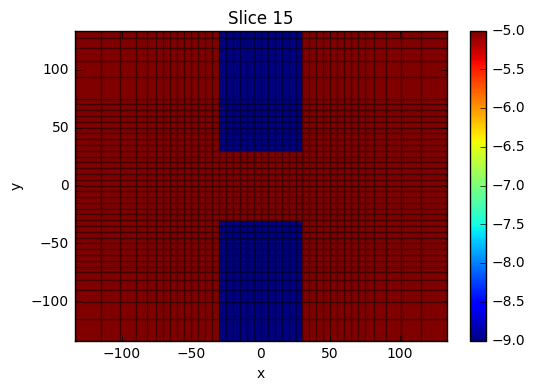

In [14]:
out = mesh.plotSlice(np.log10(K), grid=True, ind= 15, normal="Z", clim=(-9, -5))
plt.colorbar(out[0])

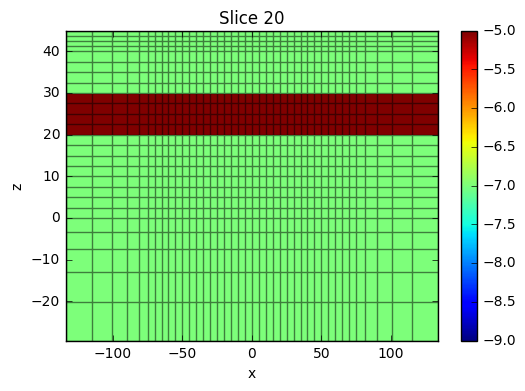

In [15]:
out = mesh.plotSlice(np.log10(K), grid=True, normal="Y", clim=(-9, -5))
plt.colorbar(out[0])

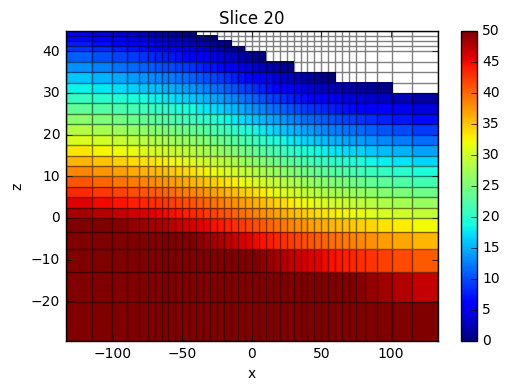

In [16]:
p = Darcyprb.p(h)
p[p<0.] = np.nan
out = mesh.plotSlice(p, grid=True, normal="Y", clim=(0, 50))
plt.colorbar(out[0])

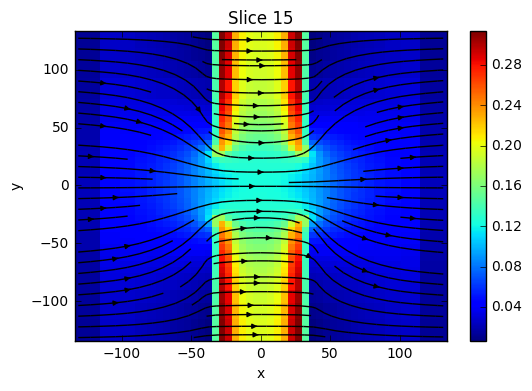

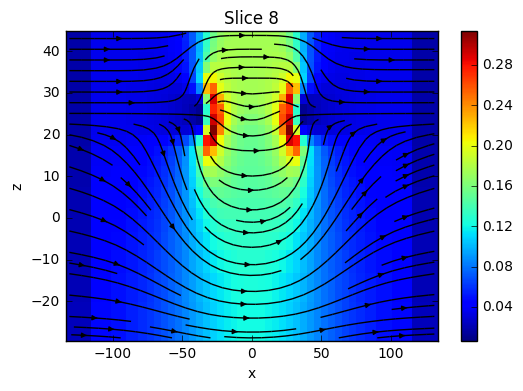

In [17]:
out = mesh.plotSlice(gradh, grid=False, normal="Z", view="vec", vType="F", ind=15)
plt.colorbar(out[0])
out = mesh.plotSlice(gradh, grid=False, normal="Y", view="vec", vType="F", clim=out[0].get_clim(), ind =8)
plt.colorbar(out[0])

In [18]:
fxm, fxp, fym, fyp, fzm, fzp = mesh.faceBoundaryInd
find = np.r_[fxm+fxp, fym+fyp, fzm+fzp]
vel[find] = 0.

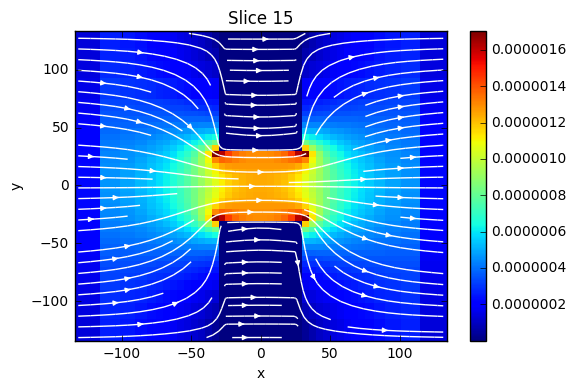

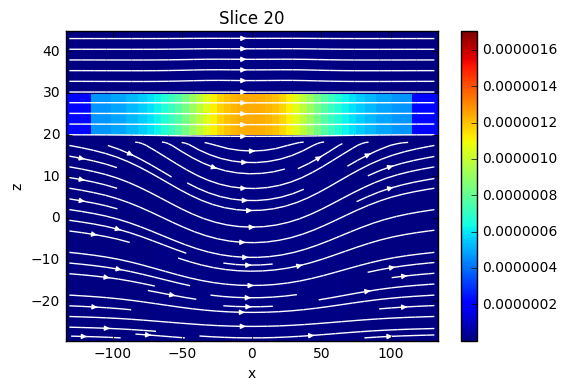

In [19]:
out = mesh.plotSlice(vel, normal="Z", view="vec", vType="F", streamOpts={"color":"w"}, ind=15)
plt.colorbar(out[0])
mesh.plotSlice(vel, normal="Y", view="vec", vType="F", clim=out[0].get_clim(), streamOpts={"color":"w"})
plt.colorbar(out[0])

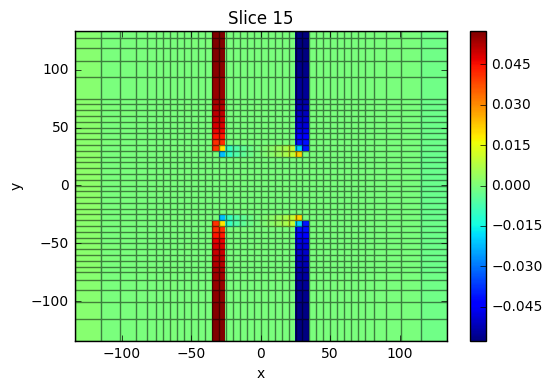

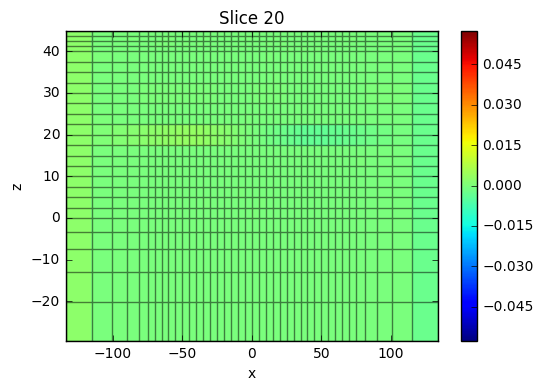

In [20]:
out = mesh.plotSlice(Darcyprb.divgradh(h), grid=True, normal="Z", ind=15)
plt.colorbar(out[0])
mesh.plotSlice(Darcyprb.divgradh(h), grid=True, normal="Y", clim=out[0].get_clim())
plt.colorbar(out[0])

In [21]:
L0 = 1e-5
# jsCC = np.r_[Qv, Qv, Qv]*(mesh.aveF2CCV*vel) 

In [22]:
dx = 5.
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx<150., mesh.vectorCCx>-150.)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy<150., mesh.vectorCCy>-150.)]
xyzM = Utils.ndgrid(x*0., y*0., np.r_[mesh.vectorCCz[-1]])
xyzN = Utils.ndgrid(x, y, np.r_[mesh.vectorCCz[-1]])

In [23]:
sigma = np.ones(mesh.nC)*1e-3
sigma[layerind1] = 1e-3
sigma[blkind1 & layerind1] = 1e-1

prb = SP.Problem_CC(mesh, sigma=sigma, hMap=Maps.IdentityMap(mesh), Solver=PardisoSolver)
rx = SP.Rx.Dipole(xyzN, xyzM)
src = SP.Src.StreamingCurrents([rx], L=np.ones(mesh.nC)*L0, mesh=mesh, modelType="Head")
survey = SP.Survey([src])
survey.pair(prb)
dobs = survey.dpred(h)
q = src.eval(prb)

In [24]:
prb = SP.Problem_CC(mesh, sigma=sigma, qMap=Maps.IdentityMap(mesh), Solver=PardisoSolver)
rx = SP.Rx.Dipole(xyzN, xyzM)
src = SP.Src.StreamingCurrents([rx], L=np.ones(mesh.nC)*L0, mesh=mesh, modelType="CurrentSource")
survey = SP.Survey([src])
survey.pair(prb)

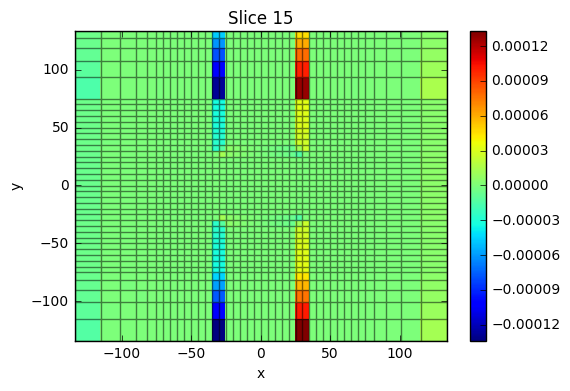

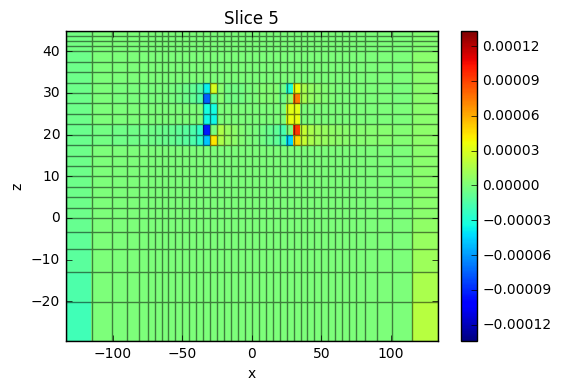

In [25]:
out = mesh.plotSlice(q, grid=True, normal="Z", ind=15)
plt.colorbar(out[0])
mesh.plotSlice(q, grid=True, normal="Y", clim=out[0].get_clim(), ind=5)
plt.colorbar(out[0])

In [26]:
# # Generate Full sensitivity
# I = np.diag(np.ones_like(dobs))
# J = np.zeros((dobs.size, mesh.nC))
# for i in range(dobs.size):
#     J[i,:] = prb.Jtvec(sigma, I[:,i])
#     JtJ = (J**2).sum(axis=0)
# JtJ /= JtJ.max()
# prb.G = J

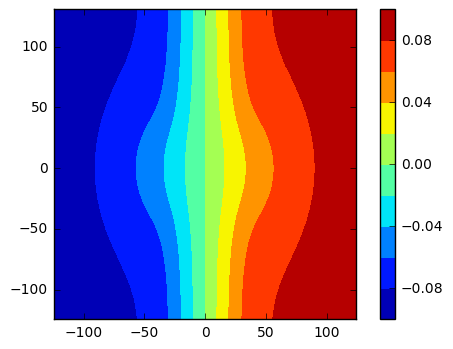

In [27]:
out = Utils.plot2Ddata(xyzN, dobs*1e3)
plt.colorbar(out[0])

In [28]:
mesh.vectorCCz[-1]

44.374999999999993

In [29]:
mesh.vectorCCz[-1]

44.374999999999993

In [30]:
depthweight = 1./ ((abs(mesh.gridCC[:,2]-mesh.vectorCCz[-1])+0.5)**1.)
depthweight /= depthweight.max()

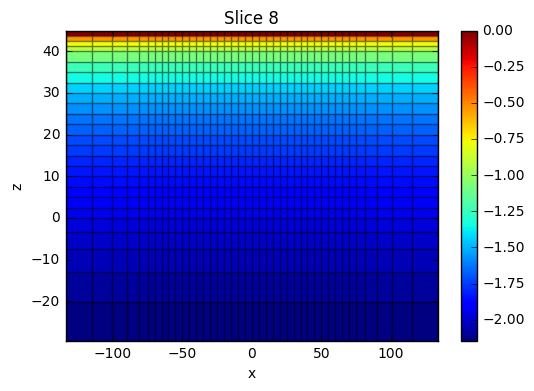

In [31]:
out = mesh.plotSlice(np.log10(depthweight), grid=True, normal="Y", ind=8)
plt.colorbar(out[0])

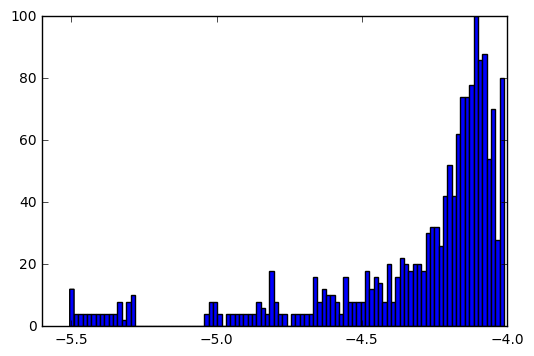

In [32]:
out = hist(np.log10(abs(dobs)), bins=100)

In [33]:
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)
survey.std = 0.02
# survey.eps = abs(dobs).max()*0.05
survey.eps = 1e-6
survey.dobs = dobs
 
dmisfit = DataMisfit.l2_DataMisfit(survey)
regmap = Maps.IdentityMap(nP = mesh.nC)
reg = Regularization.Sparse(mesh, mapping=regmap, cell_weights = depthweight)
# reg = Regularization.Simple(mesh, mapping=regmap)
reg.alpha_s = 1.
reg.alpha_x = 0.1
reg.alpha_y = 1.
reg.alpha_z = 0.1
opt = Optimization.ProjectedGNCG(maxIter=50, tolX=1e-20, tolF=1e-20)
opt.maxIterLS = 20
IRLS = Directives.Update_IRLS(norms=([0.,1.,1.,1.]),
                                     eps=(0.0001, 0.0001), f_min_change=1e-3,
                                     minGNiter=3)
IRLS.maxIRLSiter = 10
# senseweight = Directives.Update_Wj()
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
target = Directives.TargetMisfit()
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig()
betaest.beta0_ratio = 1.
updateprecond = Directives.Update_lin_PreCond()
invProb.beta = 1e8
# inv = Inversion.BaseInversion(invProb, directiveList=[beta, target])
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS])
prb.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
m0 = np.ones(mesh.nC)*0.
reg.mref = m0*0.
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+08  5.57e+05  0.00e+00  5.57e+05    3.94e+09      0              
   1  5.00e+07  1.83e+04  8.59e-10  1.83e+04    1.63e+08      0              
   2  2.50e+07  3.68e+03  1.65e-09  3.68e+03    1.37e+11      0   Skip BFGS  
   3  1.25e+07  3.68e+03  1.65e-09  3.68e+03    6.51e+07      0              
   4  6.25e+06  1.47e+03  2.05e-09  1.47e+03    2.09e+07      0              
   5  3.12e+06  8.03e+02  2.23e-09  8.03e+02    4.30e+09      0              
Convergence with smooth l2-norm regularization: Start IRLS steps...
L[p qx qy qz]-norm : [0.0, 1.0, 1.0, 1.0]

In [34]:
xc = opt.recall("xc")

In [35]:
# fig = plt.figure(figsize = (12, 4))
# ax = plt.subplot(111)
# ax_1 = ax.twinx()
# out = ax.hist(abs(reg.l2model), bins=100)
# ax.set_xscale("linear")
# ax.set_yscale("log")
# temp = np.sort(abs(reg.l2model))
# ax_1.plot(temp, temp / (temp**2 + (reg.eps_p)**2))
# plt.xlim(0, 0.0006)

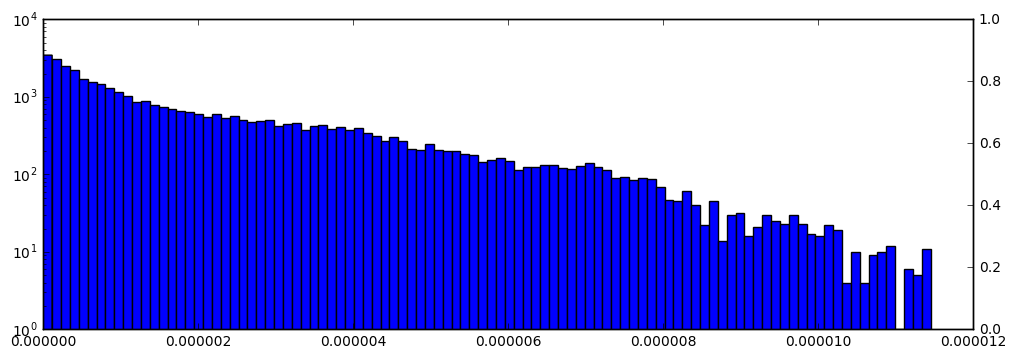

In [36]:
fig = plt.figure(figsize = (12, 4))
ax = plt.subplot(111)
ax_1 = ax.twinx()
out = ax.hist(abs(mopt), bins=100)
ax.set_xscale("linear")
ax.set_yscale("log")
temp = np.sort(abs(mopt))
# ax_1.plot(temp, temp / (temp**2 + (reg.eps_p)**2))
# plt.xlim(0, 0.0006)

In [37]:
0.00001

1e-05

In [38]:
# out = mesh.plotSlice(reg.l2model, grid=True, normal="Z", ind=15, clim=(-0.0001, 0.0001))
# plt.colorbar(out[0])
# mesh.plotSlice(reg.l2model, grid=True, normal="Y", clim=out[0].get_clim(), ind=5)
# plt.colorbar(out[0])

In [39]:
print mopt.min()
print mopt.max()

-1.14516088645e-05
1.14314057589e-05


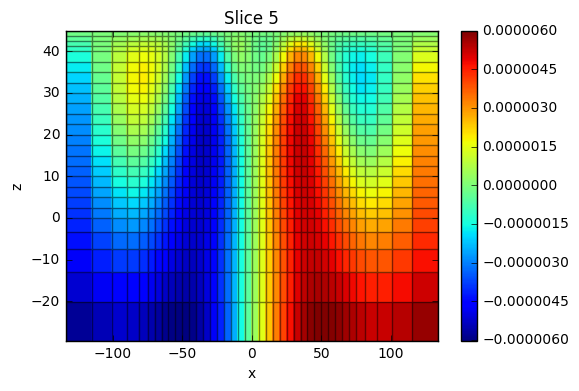

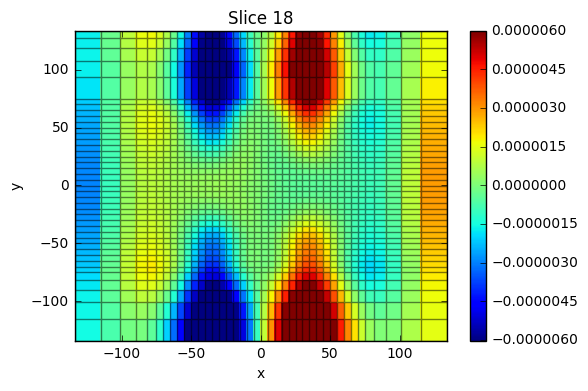

In [40]:
out = mesh.plotSlice(mopt, grid=True, normal="Y", ind=5)
plt.colorbar(out[0])
out = mesh.plotSlice(mopt, grid=True, normal="Z", ind=18, clim=out[0].get_clim())
plt.colorbar(out[0])

In [41]:
# plt.plot(survey.dobs)
# plt.plot(invProb.dpred)

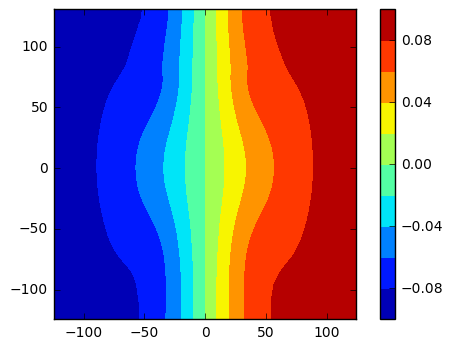

In [42]:
out = Utils.plot2Ddata(xyzN, invProb.dpred*1e3)
plt.colorbar(out[0])